In [18]:
from commonfunctions import *
import cv2  as cv
import imutils
import numpy as np
import pandas as pd 


from skimage.filters import threshold_local
from skimage import measure
import os

In [19]:
def calculate_contour_distance(contour1, contour2): # 
    x1, y1, w1, h1 = cv.boundingRect(contour1)
    c_x1 = x1 + w1/2
    c_y1 = y1 + h1/2

    x2, y2, w2, h2 = cv.boundingRect(contour2)
    c_x2 = x2 + w2/2
    c_y2 = y2 + h2/2

    return (abs(c_x1 - c_x2) , abs(c_y1 - c_y2))

def merge_contours(contour1, contour2):
    return np.concatenate((contour1, contour2), axis=0)

def agglomerative_cluster(contours, threshold_distance=110.0):
    current_contours = contours
    while len(current_contours) > 1:
        min_distance = None
        min_coordinate = None
        
        for x in range(len(current_contours)-1):
            for y in range(x+1, len(current_contours)):
                distancex,distancey = calculate_contour_distance(current_contours[x], current_contours[y])
                if min_distance is None and distancey <= 25:
                    min_distance = distancex
                    min_coordinate = (x, y)
                elif  min_distance != None and distancex < min_distance and distancey <= 25:
                    min_distance = distancex
                    min_coordinate = (x, y)
        
        if  min_distance != None and min_distance < threshold_distance :
            index1, index2 = min_coordinate
            current_contours[index1] = merge_contours(current_contours[index1], current_contours[index2])
            del current_contours[index2]
        else:
            break

    return current_contours


In [12]:
def LPD(img):
    
    #? Step 1: Edge Detection
    #img = cv.resize(img, (1200,1200), interpolation=cv.INTER_CUBIC)

   
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = gray[gray.shape[0]*2//5:gray.shape[0],:]
    #show_images([gray])
    gray = cv.GaussianBlur(gray, (3,3),0)
    img = img[img.shape[0]*2//5:img.shape[0],:]
    
    # The Black Hat operation is the difference between the closing and input image 
    
    rectKern = cv.getStructuringElement(cv.MORPH_RECT, (7,5))
    blackhat = cv.morphologyEx(gray, cv.MORPH_BLACKHAT, rectKern)
    #show_images([blackhat])


    img_thresh = blackhat
    img_thresh[ img_thresh < 50 ] = 0
    img_thresh[ img_thresh >= 50 ] = 255
    #show_images([img_thresh])
    
    sobel_x = cv.Sobel(img_thresh, cv.CV_64F, 1, 0, ksize=3)  # Gradient in x-direction
    sobel_x = np.absolute(sobel_x)
    maxVal = np.max(sobel_x)
    sobel_x = 255 * ((sobel_x) / (maxVal))
    sobel_x = sobel_x.astype("uint8")
    #show_images([sobel_x])

    
    closeKern = cv.getStructuringElement(cv.MORPH_RECT, (7,7))
    closed_image = cv.morphologyEx(sobel_x, cv.MORPH_CLOSE, closeKern)
    #show_images([closed_image])
    
    
    temp1= cv.erode(closed_image, None, iterations = 2)
    temp1 = cv.dilate(temp1, None, iterations = 3)
    #show_images([temp1])
    tempx= cv.erode(temp1, None, iterations = 2)
    tempx = cv.dilate(tempx, None, iterations = 3)
    #show_images([tempx])
    
    tempx[ tempx < 140 ] = 0
    tempx[ tempx >= 140 ] = 255
    #show_images([tempx],["Binraization new"])
    
    
    temp2 = cv.erode(tempx, None, iterations = 2)
    temp2 = cv.dilate(temp2, None, iterations = 9)
    
    #show_images([temp2])
    
#     temp2 = cv.erode(temp2, None, iterations = 2)
#     temp2 = cv.dilate(temp2, (5,9), iterations = 6)
    kkk = cv.getStructuringElement(cv.MORPH_RECT, (7,1))
    temp2 = cv.dilate(temp2, kkk, iterations = 3)
        
#    #show_images([temp2],["hello world !!!!!!"])
    
    
    img1_thresh = temp2

   #show_images([img1_thresh])

    
    contours, hierarchy = cv.findContours(img1_thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #get the contours

    merged_contours = []
    copyContours = list(contours)
    merged_contours = agglomerative_cluster(copyContours) # merge contours which is close together
    
    cnts = sorted(merged_contours, key=cv.contourArea, reverse=True)
    
    
    img_cont = img.copy()
    cv.drawContours(img_cont,cnts,-1, (0, 255, 0), 2)
    
    for cnt in cnts:

        area = cv.contourArea(cnt)
        x1, y1, w1, h1 = cv.boundingRect(cnt)
        c_x1 = x1 + w1/2
        c_y1 = y1 + h1/2
        
        text = f"x: {c_x1}, y: {c_y1}"
        cv.putText(img_cont, text, (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        
        if 500 < area < 15000: # filter on the area of the contours 
        
        
            peri = cv.arcLength(cnt, True)
            approx = cv.approxPolyDP(cnt, 0.02 * peri, True)
            x, y, w, h = cv.boundingRect(approx)
            ar = w / float(h)

            if (ar>=1.5 and ar<=6):
                #cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cropped_image = img[y:y + h, x:x + w]
                #show_images([cropped_image])
                return cropped_image

In [27]:
def test(plate_img):
    V = cv.split(cv.cvtColor(plate_img, cv.COLOR_BGR2HSV))[2]
  
    #     thresh = cv.adaptiveThreshold(V, 255,
#                                    cv.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                    cv.THRESH_BINARY,
#                                    11, 2)

    thresh = V
#     thresh = cv.GaussianBlur(thresh, (5, 5), sigmaX=1)
    thresh = cv.bitwise_not(thresh)
    plate_img = imutils.resize(plate_img, width = 200)
    thresh = imutils.resize(thresh, width = 200)
    bgr_thresh = cv.cvtColor(thresh, cv.COLOR_GRAY2BGR)
    
    thresh[ thresh < 120 ] = 0
    thresh[ thresh >= 120] = 255
        
    labels = measure.label(thresh, background = 0)

 
    # loop over the unique components
    imagg = np.zeros(thresh.shape, dtype ='uint8')

    for label in np.unique(labels):
    
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask to display
        # only connected components for the current label,
        # then find contours in the label mask
        labelMask = np.zeros(thresh.shape, dtype ='uint8')
        labelMask[labels == label] = 255     
        
        cnts = cv.findContours(labelMask,
                     cv.RETR_EXTERNAL,
                     cv.CHAIN_APPROX_SIMPLE)
        
        cnts = cnts[1] if imutils.is_cv3() else cnts[0] # for cv2 and cv3
        
        if len(cnts) > 0:
                c = max(cnts, key = cv.contourArea)
                (boxX, boxY, boxW, boxH) = cv.boundingRect(c)
                area = cv.contourArea(c)
                heightRatio = boxH / float(plate_img.shape[0])
                widthRation = boxW / float(plate_img.shape[1])
                solidity = cv.contourArea(c) / float(boxW * boxH)
                if(area >0 and area<700 and heightRatio  <0.9 and widthRation< 0.2  and solidity < 0.80):
                    imagg = cv.bitwise_or(imagg,labelMask)
                    #show_images([imagg],["i love egypt"])
                
    morph_kern = cv.getStructuringElement(cv.MORPH_RECT, (1,4))
    dilated = cv.dilate(imagg,morph_kern,iterations=3)
    #show_images([plate_img,thresh,imagg,dilated])
    
    return [dilated,plate_img]
    
    
    

In [30]:
def extractChars(img,path):
        show_images([img[0],img[1]])
        labels = measure.label(img[0], background = 0)
        charCandidates = np.zeros(img[1].shape, dtype ='uint8')
        arr =[]
        for idx,label in enumerate(np.unique(labels)):
                                  
            if label == 0:
                continue
            # otherwise, construct the label mask to display
            # only connected components for the current label,
            # then find contours in the label mask
            labelMask = np.zeros(img[0].shape, dtype ='uint8')
            labelMask[labels == label] = 255

            cnts = cv.findContours(labelMask,
                     cv.RETR_EXTERNAL,
                     cv.CHAIN_APPROX_SIMPLE)
        
            cnts = cnts[1] if imutils.is_cv3() else cnts[0] # for cv2 and cv3
           

            # ensure at least one contour was found in the mask
            if len(cnts) > 0:

                # grab the largest contour which corresponds
                # to the component in the mask, then grab the
                # bounding box for the contour
                c = max(cnts, key = cv.contourArea)
                (boxX, boxY, boxW, boxH) = cv.boundingRect(c)

                # compute the aspect ratio, solodity, and
                # height ration for the component
                aspectRatio = boxW / float(boxH)
                solidity = cv.contourArea(c) / float(boxW * boxH)
                heightRatio = boxH / float(img[1].shape[0])
                center_contour = boxY+(boxH/2)
                area = cv.contourArea(c)
#                 print("center_contour:",center_contour)
                
                # determine if the aspect ratio, solidity,
                # and height of the contour pass the rules
                # tests
                keepAspectRatio =  aspectRatio < 1
#               keepSolidity = solidity < 0.0

                areaRatio =  area > 70 and area < 1000
                solidity = cv.contourArea(c) / float(boxW * boxH)
                center_line=img[1].shape[0] // 2
#                 print(f"c_b{center_line-th} , c_a{center_line+th}")
#                 print(img[1].shape)
#                 check to see if the component passes
#                 all the tests
#                    and keepHeight and boxW > 14
                if keepAspectRatio  and areaRatio and solidity < 0.78:
                    # copy_image = plate_img.copy()
                    if((center_line > boxY and center_line < boxY+boxH) or (center_line<boxY) ) :
                        cropped_image = img[1][boxY:boxY + boxH, boxX:boxX + boxW]
                        cv.imwrite(f'{path}{idx}.jpg', cropped_image)
    #                     arr.append(cropped_image)
    #                     show_images([cropped_image])
                        cv.rectangle( img[1], (boxX, boxY), (boxX + boxW, boxY + boxH), (0, 255, 0), 1)

        
        cv.line(img[1], (0,img[1].shape[0]//2), ((img[1].shape[1],img[1].shape[0]//2,)), (255,0,0), 1)
        show_images([img[1]])

#    contours, hier = cv.findContours(charCandidates,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
     

#     if contours:
#         contours = sort_cont(contours)
          
#         # value to be added to each dimension
#         # of the character
#         addPixel = 4
#         for c in contours:
#             (x, y, w, h) = cv.boundingRect(c)
#             if y > addPixel:
#                 y = y - addPixel
#             else:
#                 y = 0
#             if x > addPixel:
#                 x = x - addPixel
#             else:
#                 x = 0
#             temp = bgr_thresh[y:y + h + (addPixel * 2),
#                               x:x + w + (addPixel * 2)]
            
  
    #             show_images([temp,plate_img])
#             characters.append(temp)
              
#         return characters
      
#     else:
#         return None
    
    

['0450.jpg']


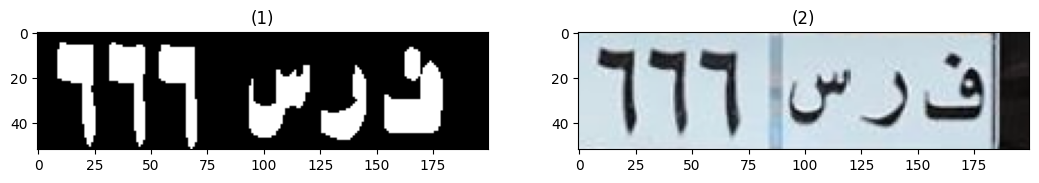

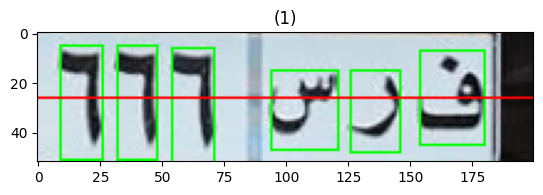

In [35]:
import os
images = os.listdir('test_ocr')
print(images)
for image in images:
    extractChars(test(LPD(cv.imread('test_ocr/'+image))),image)

# test(LPD(cv.imread('images/0059.jpg')))